# Compare Handwritten Signatures using VGG19 and Cosine Similarity

In [6]:
import os
import matplotlib.pyplot as plt
from progressbar import progressbar
import warnings
warnings.filterwarnings('ignore')

def show(img, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

In [24]:
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

In [25]:
model = VGG19(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Some sample prediction

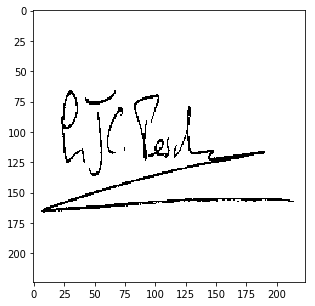

(1, 7, 7, 512)


In [26]:
img_path = 'handwritten-signatures/sample_Signature/genuine/NFI-00102001.png'
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

vgg16_feature = model.predict(img_data)

show(img)
print(vgg16_feature.shape)

## Predict for all images

In [667]:
# define path
path = 'handwritten-signatures/sample_Signature/genuine'

# define input filenames
filenames = os.listdir(f'{path}/')

sig = dict()
for fname in progressbar(filenames):
    try:
        img = image.load_img(f'{path}/{fname}', target_size=(224, 224))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        
        sig[fname] = [np.array(model.predict(img_data)).flatten()]
    except: 
        filenames.remove(fname)
        continue
        
sig_df = pd.DataFrame(sig).T
sig_df.head()

100% (151 of 151) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


,0
NFI-02901029.PNG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
NFI-01702017.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
NFI-00503005.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
NFI-02502025.PNG,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
NFI-00804008.png,"[0.0, 0.0, 0.0, 0.0, 63.440975, 1.62955, 0.0, ..."


## Min Sample

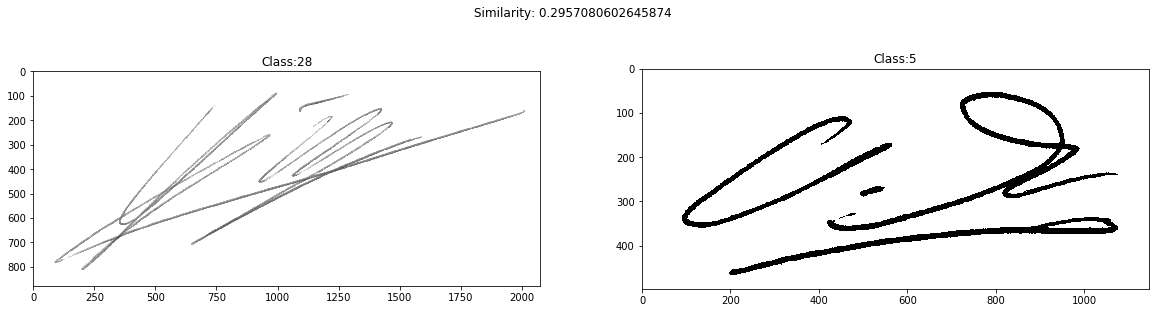

In [668]:
sample = sig_df.sample(2)
a,b = sample.index[0], sample.index[1]
sim = 1.0 - cosine(sig_df.T[a][0], sig_df.T[b][0])

a_class, b_class = int(a.strip('.png').strip('.PNG')[-3:]), int(b.strip('.png').strip('.PNG')[-3:])


plt.figure(figsize=(20,5))
plt.suptitle(f'Similarity: {sim}')

plt.subplot(1,2,1)
plt.title(f"Class:{a_class}")
plt.imshow(image.load_img(f'{path}/{a}'))

plt.subplot(1,2,2)
plt.title(f"Class:{b_class}")
plt.imshow(image.load_img(f'{path}/{b}'))


plt.show()

## Find Optimall Treshhold

In [678]:
from math import factorial as fat
n = len(sig_df.index)
nof_combination = lambda n,p: fat(n)/(fat(n-p)*fat(p))
nof_combination(n,2)

11026.0

In [679]:
from itertools import combinations
comb =  [i for i in combinations(sig_df.index, 2)]
len(comb)

11026

In [671]:
#dinamic programing for computing all similarities
sims = dict()
for a,b in comb:
    not_in_dict = False

    if not(a in sims):
        sims[a] = dict()
        not_in_dict = True
    if not(b in sims):
        sims[b] = dict()
        not_in_dict = True
    if not(a in sims[b]):
        sims[b][a] = dict()
        not_in_dict = True
    if not(b in sims[a]):
        sims[a][b] = dict()
        not_in_dict = True

    if not_in_dict:
        sim = 1.0 - cosine(sig_df.T[a][0], sig_df.T[b][0])
        sims[b][a]['dist'] = sim
        sims[a][b]['dist'] = sim

        label = int(a.strip('.png').strip('.PNG')[-3:]) == int(b.strip('.png').strip('.PNG')[-3:])
        sims[b][a]['label'] = label
        sims[a][b]['label'] = label

In [672]:
x = list()
y = list()
for thresh in np.linspace(0,1, 200):
    x.append(thresh)
    y.append(0)
    for a,b in combinations(sig_df.index, 2):
        predicted = sims[a][b]['dist'] > thresh
        y[-1] += 1 if predicted != sims[a][b]['label'] else 0

optimal_threshhold = x[y.index(min(y))]

x = np.array(x)
y = 1 - np.array(y) / len(comb)

minimum_loss = max(y)

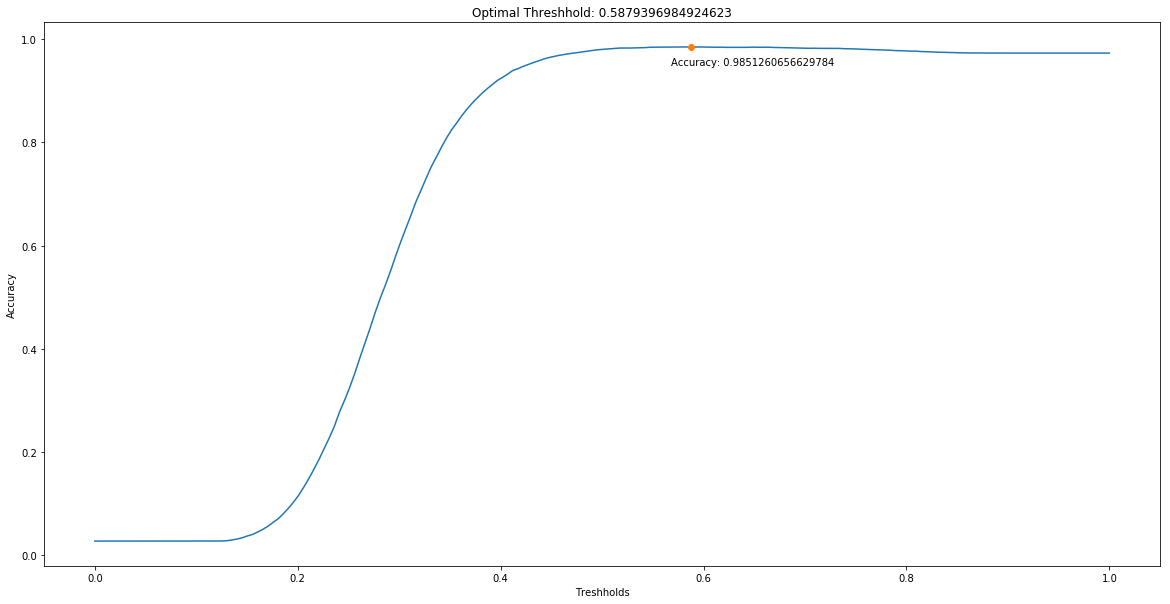

In [673]:
plt.figure(figsize=(20,10))
plt.title(f'Optimal Threshhold: {optimal_threshhold}')
plt.plot(x,y)
plt.annotate(f'Accuracy: {minimum_loss}', xy=(optimal_threshhold, minimum_loss), xytext=(optimal_threshhold-0.02, 0.95))
plt.plot(optimal_threshhold, minimum_loss, 'o', )
plt.xlabel('Treshholds')
plt.ylabel('Accuracy')
plt.show()